In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torchaudio
import torchvision
import torchvision.transforms as transforms

from model import *
from PIL import Image
import numpy as np
import cv2

d:\TSINGHUA\NLP\Video-Captioning-AV\venv\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
AUDIO_FILE = 'video1.wav'
audio, sr = torchaudio.load(AUDIO_FILE)
print(audio.shape)
print(sr)


torch.Size([2, 970200])
44100


In [3]:
encoder_a = AudioEncoder().cuda()
# features = encoder_a(audio.permute(1,0).numpy(), sr=sr)
features = encoder_a.from_tensor(audio, sr)
# features = encoder_a(AUDIO_FILE)
print(features.shape)

Using cache found in C:\Users\hector/.cache\torch\hub\harritaylor_torchvggish_master
torch.Size([22, 128])


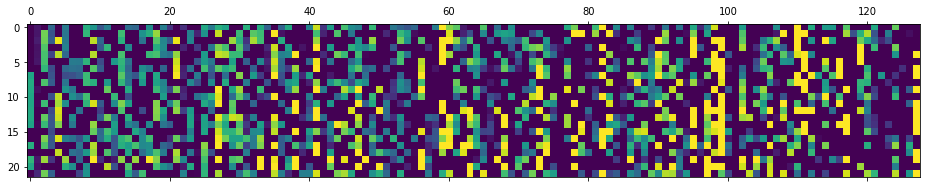

In [4]:
plt.matshow(features.detach().cpu().numpy())
plt.show()

In [9]:
def load_frames(video_filename, frame_size=(299,299), take_n=0, take_max=None, fps=None):
    frames = []
    cap = cv2.VideoCapture(VIDEO_FILENAME)
    
    frame_rate = np.round(cap.get(cv2.CAP_PROP_FPS))

    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, frame_size, interpolation=cv2.INTER_AREA)
            frames.append(frame)
        else:
            break

    frames = np.array(frames)

    # Downsample the video to the specified fps
    if fps and fps < frame_rate:
        total_frames = frames.shape[0]
        take_n = int(frames.shape[0] // frame_rate * fps)

    if take_max and frames.shape[0] > take_max:
        take_n = take_max

    if take_n > 0:
        total_frames = frames.shape[0]
        frame_idx = np.arange(0, total_frames, total_frames//take_n)
        frames = frames[frame_idx,:,:,:]

    return frames

In [7]:
encoder_v = ImageEncoder(model='inception_v3').cuda()

In [10]:
VIDEO_FILENAME = os.path.join('datasets', 'MSVD', 'videos', '_0nX-El-ySo_83_93.avi')
frames = load_frames(VIDEO_FILENAME, fps=1)
print(frames.shape)

(10, 299, 299, 3)


In [18]:
frames_t = torch.Tensor(frames).permute(0,3,1,2).unsqueeze(0)
# frames_t = torch.cat([frames_t, frames_t], dim=0)
print(frames_t.shape)

video_features = encoder_v(frames_t.cuda())
print(video_features.shape)

torch.Size([1, 10, 3, 299, 299])
torch.Size([1, 10, 1000])


In [6]:
# vframes, aframes, info = torchvision.io.read_video(VIDEO_FILENAME)

In [32]:
video_transforms = transforms.Compose(
    [
        # transforms.ToPILImage(),
        # transforms.Resize((299, 299)),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.unsqueeze(0)
    ]
)

frames_tr = list(map(video_transforms, [frames[i,] for i in range(frames.shape[0])]))
frames_tr = torch.cat(frames_tr, dim=0)

print(frames_tr.shape)

# video_features = list(map(lambda x: encoder_v(img_transforms(x).unsqueeze(0).cuda()).detach().cpu(), [Image.fromarray(frames[i,]) for i in range(frames.shape[0])] )) 
# video_features = torch.cat(video_features, dim=0)

# video_features = encoder_v(frames_tr)

torch.Size([10, 3, 299, 299])


In [19]:
video_features = encoder_v(torch.Tensor(frames).unsqueeze(0).cuda())
print(video_features.shape)

RuntimeError: Calculated padded input size per channel: (149 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [5]:
plt.matshow(video_features.detach().cpu().numpy())
plt.show()

NameError: name 'video_features' is not defined